In [42]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import datetime
import warnings
import tqdm
from metpy import calc
from metpy.units import units

(c1,c2,c3,c4)=('#1b9e77','#d95f02','#7570b3','#e7298a')
warnings.simplefilter("ignore")

# Import data

In [4]:
met_dict = pickle.load(open('met_dict.p','rb'))
rawinsondes = pickle.load(open('../rawinsondes.p','rb'))

In [5]:
# times = []

# for i in df['GMT_hour']:
    
# #     print(i)
#     if '12' in i:
#         times.append(12)
#     elif '9' in i:
#         times.append(9)
        
#     else:
#         try:
#             t = int(i)
#             times.append(t)
#         except:
#             times.append(12)
            

            
# df['GMT_clean'] = times

In [6]:
frames = []

for NP, df in met_dict.items():
    
    df['doy'] = [d.timetuple().tm_yday for d in df.index]
    
    df['days_after_jan1'] = [d  if d<212 else d-365 for d in df['doy']]
    
    df['diff'] = df['Air temperature'] - df['Surface temperature']
    
    df['NP'] = NP
    
    df[df['diff']<-25] = np.nan
    
#     df[np.abs(df['days_after_jan1'])>100] = np.nan
    
    df = df[~np.isnan(df['diff'])]
    df = df[~np.isnan(df['Relative humidity'])]
    df = df[~np.isnan(df['Wind speed'])]
    
    if np.count_nonzero(np.nan_to_num(df['diff']))>100:
        
        frames.append(df)
        
df = pd.concat(frames)
df['month'] = [x.month for x in df.index]
df = df[np.isin(df['month'],[1,2,3,4,9,10,11,12])]
df = df[df['zenith']>90]
df = df[df['Surface temperature']<1]

df['code'] = [f'{dt}_{NP}' for dt, NP in zip(df.index,df['NP'])]

df['hour'] = [d.time().hour for d in df.index]
df = df[df['hour']==9]

print(df.shape)

(10335, 20)


### Now go through the dataframe row by row, and see if the row appears in the rawinsonde data

If it does, append the rawinsonde data to a list

If it doesn't, mark the row for deletion

In [7]:
list_of_dicts = []
bad_codes = []

for dt, NP, code in zip(df.index,df['NP'],df['code']):
    
    if (NP in rawinsondes.keys()) and (dt.date() in rawinsondes[NP].keys()):
    
        rs_metadata = rawinsondes[NP][dt.date()]['metadata']
        rs_metadata['code'] = code
        list_of_dicts.append(rs_metadata)
            
    else:
        bad_codes.append(code)

for code in tqdm.tqdm(bad_codes):
    df = df[df['code']!=code]

df_meta = pd.DataFrame(list_of_dicts)

df.set_index('code',inplace=True)
df_meta.set_index('code',inplace=True)

df = pd.concat([df,df_meta],axis=1)

df.head()

100%|██████████████████████████████████████| 4022/4022 [00:05<00:00, 730.80it/s]


,Latitude,Longitude,Air temperature,Relative humidity,Sea level pressure,Wind direction,Wind speed,Total cloudiness,Low cloudiness,Surface temperature,...,CLOUD_HEIGHT_QLTY,MID_CLOUD,MID_CLOUD_QLTY,HIGH_CLOUD,HIGH_CLOUD_QLTY,date,n_points,inversion_depth,inversion_temperature,precipitable_water
code,,,,,,,,,,,,,,,,,,,,,
1954-09-24 09:00:00_03,89.296,-50.481,-30.7,85.0,1015.6,45.0,2.0,0.0,0.0,-29.0,...,-9,-9,-9,-9,-9,1954-09-24,1,NaN,NaN,NaN
1954-09-25 09:00:00_03,89.272,-53.025,-22.9,89.0,1004.6,45.0,4.0,8.0,0.0,-17.0,...,-9,-9,-9,-9,-9,1954-09-25,1,NaN,NaN,NaN
1954-09-27 09:00:00_03,89.220,-57.615,-10.3,98.0,1010.2,360.0,17.0,10.0,10.0,-10.0,...,-9,-9,-9,-9,-9,1954-09-27,10,500.0,-8.3,5.890593
1954-09-29 09:00:00_03,89.163,-61.604,-8.4,97.0,1006.2,225.0,3.0,10.0,10.0,-12.0,...,-9,-9,-9,-9,-9,1954-09-29,7,2000.0,-11.3,6.819596
1954-09-30 09:00:00_03,89.133,-63.398,-15.6,95.0,1015.6,200.0,5.0,10.0,10.0,-18.0,...,-9,-9,-9,-9,-9,1954-09-30,16,1700.0,-6.4,6.428816


# Plot relationship between the temp-magnitude of the inversion aloft and the size of the surface inversion

In [8]:
df_cloudy_low = df[df['Low cloudiness']>9]
df_clear_total = df[df['Total cloudiness']<1]
df_clear_low = df[df['Low cloudiness']<1]
df_cloudy_high = df_clear_low[df_clear_low['Total cloudiness']>8]

In [9]:
def get_pw(m,bottom=None,top=None):

    temperature_metpy = np.array(m['temperature'])*units.degC
    humidity_metpy = np.array(m['humidity'])*units.percent
    dewpoint_metpy = calc.dewpoint_from_relative_humidity(temperature_metpy,humidity_metpy)
    pressure_metpy = np.array(m['pressure'])*units.hPa
    
    precipitable_water_metpy = calc.precipitable_water(pressure_metpy,dewpoint_metpy,bottom=bottom,top=top)
    
#     plt.plot(precipitable_water_metpy,m['altitude'])
    
    return precipitable_water_metpy

def get_esat_i(data):
    exp = np.exp((22.452*data['temperature'])/(272.55+data['temperature']))
    coeff = (1.0003+(4.18e-6*data['pressure']))*6.1115
    return exp*coeff

def get_esat_w(data):
    exp = np.exp((17.966*data['temperature'])/(247.15+data['temperature']))
    coeff = (1.0007+(3.46e-6*data['pressure']))*6.1121
    return exp*coeff

def get_rhi(data):
    ei = get_esat_i(data)
    ew = get_esat_w(data)
    rhi = ew*data['humidity']/ei
    return rhi
    
def interp(df, new_index):
    """Return a new DataFrame with all columns values interpolated
    to the new_index values."""
    
#     try:
#         df.set_index('altitude')
#     except:
#         pass
    
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df.index.name

    for colname, col in df.iteritems():
        df_out[colname] = np.interp(new_index, df.index, col)

    return df_out

high


100%|█████████████████████████████████████████| 941/941 [00:20<00:00, 46.67it/s]


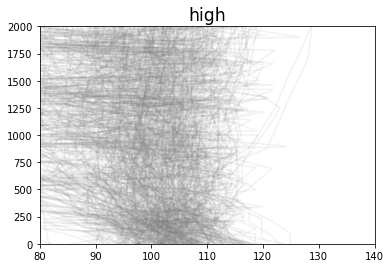

clear


100%|███████████████████████████████████████| 1585/1585 [00:34<00:00, 45.33it/s]


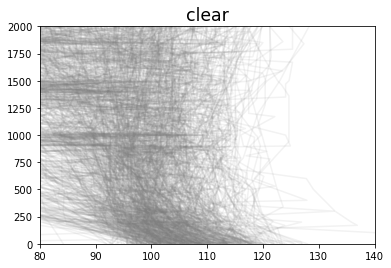

low


100%|███████████████████████████████████████| 1301/1301 [00:25<00:00, 51.81it/s]


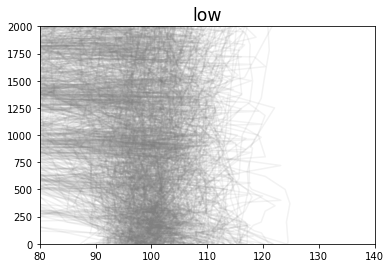

In [10]:
weather_vars = ['temperature','humidity','dewpoint','rh_i']

x = {'altitude':{}, 
     'pw_high':{},
     'pw_low':{},
     'pw_tot':{},
     'rhi_high':{},
     'rhi_low':{},
     'rhi_tot':{},
         'code':{},
         'diff':{}}

for var in weather_vars:
    x[var] = {}

for d,name in zip([df_cloudy_high,df_clear_total,df_cloudy_low],['high','clear','low']):
    
    print(name)
    
    for key in x.keys():
        x[key][name] = []
        
    
    
    for i in tqdm.tqdm(d.index):

        if d.loc[i]['n_points'] > 10:
            if d.loc[i]['min_altitude'] < 50:
                if d.loc[i]['max_altitude'] > 8000:


                    NP = d.loc[i]['NP']

                    data =  rawinsondes[NP][df['date'].loc[i]]['data']


                    pw = rawinsondes[NP][df['date'].loc[i]]['metadata']['precipitable_water']

        #             x['pw'][name].append(np.array(df['precipitable_water'].loc[i]))

                    data = data[data['humidity']<100]
                    data = data[data['humidity']>0]
                    data = data[data['altitude']>=0]

                    data['rh_i'] = get_rhi(data)
                    
                    d_ = data.copy()
                    
                    d_.set_index('altitude',inplace=True)

                    data = interp(d_,np.arange(np.min(data['altitude']),8_000,10))

                    plt.plot(data['rh_i'],data.index,alpha=0.1,color='grey')
                    
#                     levels = data['']
                
#                     try:
                    x['code'][name].append(i)

                    x['pw_low'][name].append(get_pw(data,top=780*units.hPa).magnitude)
                    x['pw_tot'][name].append(get_pw(data).magnitude)
                    x['pw_high'][name].append(get_pw(data,bottom=780*units.hPa).magnitude)

                    x['rhi_low'][name].append(np.nanmean(data['rh_i'][data.index<100]))
                    x['rhi_tot'][name].append(np.nanmean(data['rh_i']))
                    x['rhi_high'][name].append(np.nanmean(data['rh_i'][data.index>2000]))

                    x['diff'][name].append(d.loc[i]['diff'])


                    for var in weather_vars:
                        x[var][name]+=list(data[var])
                    x['altitude'][name]+=list(data.index)
#                     except Exception as e:
#                         pass
#                         print(e)
                        
    plt.title(name,fontsize='xx-large')
    plt.xlim(80,140)
    plt.ylim(0,2_000)
    plt.show()

LinregressResult(slope=0.9073442762895677, intercept=0.8123639044908844, rvalue=0.7040891540864637, pvalue=1.0681676646819872e-60, stderr=0.04604394215378142, intercept_stderr=0.11537687013047765)


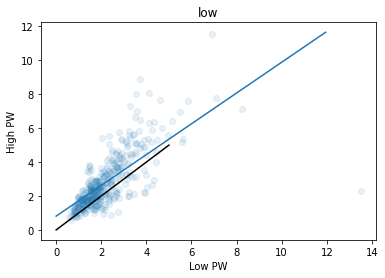

LinregressResult(slope=1.0122167560035185, intercept=0.15072374673260502, rvalue=0.8594933864517845, pvalue=3.04095618663192e-100, stderr=0.03279153409848171, intercept_stderr=0.0629220805699387)


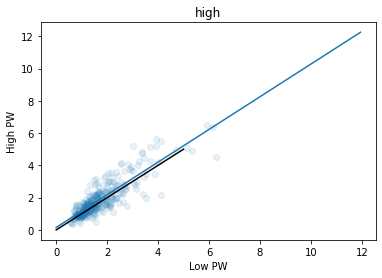

LinregressResult(slope=0.9156470307425664, intercept=0.2789681962637922, rvalue=0.7259654185069014, pvalue=2.112685530609043e-87, stderr=0.037857439500172764, intercept_stderr=0.04638865371597064)


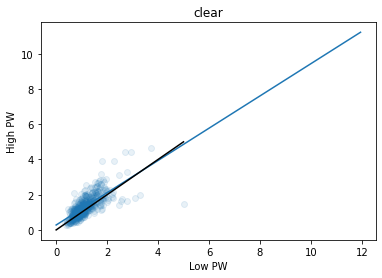

In [14]:
for name in ['low','high','clear']:

    dic = {}

    for var in ['pw_low','pw_high']:

        code, pw = x['code'][name],x[var][name]

        valid = df.loc[code].copy()

        valid['pw_clean'] = pw
        valid = valid[valid['min_altitude']<100]
        valid = valid[valid['max_altitude']>10_000]

        valid = valid.dropna()

        dic[var] = valid['pw_clean']
        
    pwcorr = pd.concat([dic['pw_low'],dic['pw_high']],axis=1)
    pwcorr.columns = {'pw_low','pw_high'}
    
    pwcorr.dropna(inplace=True)
    lr = linregress(pwcorr['pw_low'],pwcorr['pw_high'])
    
    print(lr)
    
    xa=np.arange(0,12,0.05)
    plt.plot(xa,xa*lr[0]+lr[1])
    
    plt.scatter(pwcorr['pw_low'],pwcorr['pw_high'],alpha=0.1)
    plt.plot([0,5],[0,5],color='k')
    plt.title(name)
    plt.xlabel('Low PW')
    plt.ylabel('High PW')
    plt.show()
    

pw_tot
LinregressResult(slope=-0.6505066632983216, intercept=2.406240022404812, rvalue=-0.5456762391274362, pvalue=4.160771597623551e-05, stderr=0.14419097493212518, intercept_stderr=0.5072249344210844)
LinregressResult(slope=-0.01950574750209832, intercept=0.052898918726939886, rvalue=-0.05854393830817525, pvalue=0.6458642788190535, stderr=0.04224149610618997, intercept_stderr=0.25914604354962445)
LinregressResult(slope=-0.5330704125436699, intercept=3.3182907001753565, rvalue=-0.24234882031403304, pvalue=0.014122198862094005, stderr=0.2134027914557538, intercept_stderr=0.5108279915014664)


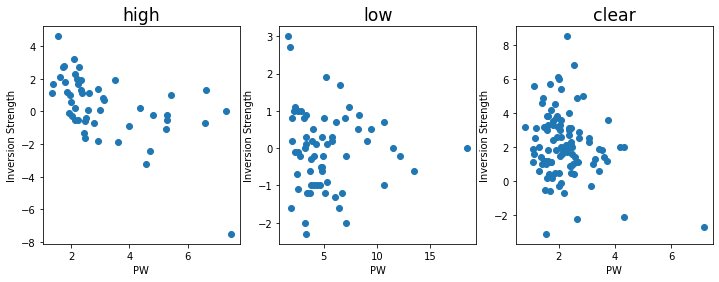

pw_low
LinregressResult(slope=-1.108512999400164, intercept=2.192279315871601, rvalue=-0.5489664692296559, pvalue=3.0288662040624584e-05, stderr=0.24111395939669822, intercept_stderr=0.45575286166803847)
LinregressResult(slope=-0.02256090013174306, intercept=0.00588140509242388, rvalue=-0.043025322251207275, pvalue=0.7336243914296354, stderr=0.06600239057450899, intercept_stderr=0.2405336061778677)
LinregressResult(slope=-0.7316575937418566, intercept=2.80411136783666, rvalue=-0.1919719362519977, pvalue=0.04073834098674766, stderr=0.3534332183322333, intercept_stderr=0.44746591049650786)


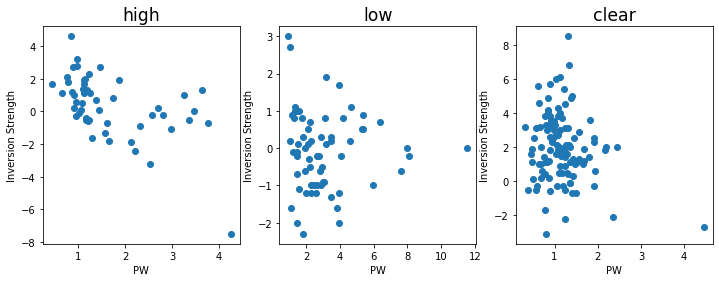

pw_high
LinregressResult(slope=-1.3459796755927027, intercept=2.357808422305449, rvalue=-0.5007231990826737, pvalue=0.00021275042156861665, stderr=0.33584675903764705, intercept_stderr=0.5507826833324482)
LinregressResult(slope=-0.06886582232124557, intercept=0.10276351258546187, rvalue=-0.07978538138928805, pvalue=0.5308537360461223, stderr=0.10926922264248069, intercept_stderr=0.2760459288026821)
LinregressResult(slope=-1.0496898413419407, intercept=3.2402260687737927, rvalue=-0.21040360572660377, pvalue=0.033786964415871285, stderr=0.4877255404993528, intercept_stderr=0.5488623110391897)


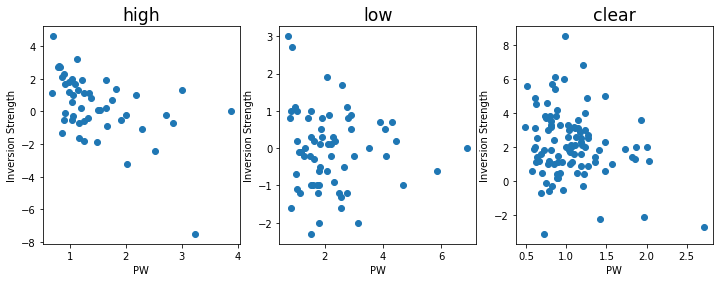

rhi_low
LinregressResult(slope=-0.03101173546138273, intercept=3.594890606229661, rvalue=-0.1075677768020509, pvalue=0.4524557188010524, stderr=0.0409466725466337, intercept_stderr=4.270714471804259)
LinregressResult(slope=-0.01707035301839667, intercept=1.6598394283526308, rvalue=-0.08685147648248523, pvalue=0.4949804826265203, stderr=0.024867106957637122, intercept_stderr=2.5193264561058064)
LinregressResult(slope=-0.029640718106450605, intercept=5.115080220576574, rvalue=-0.12479794504193123, pvalue=0.1858449610005505, stderr=0.02226710192440076, intercept_stderr=2.378329120739892)


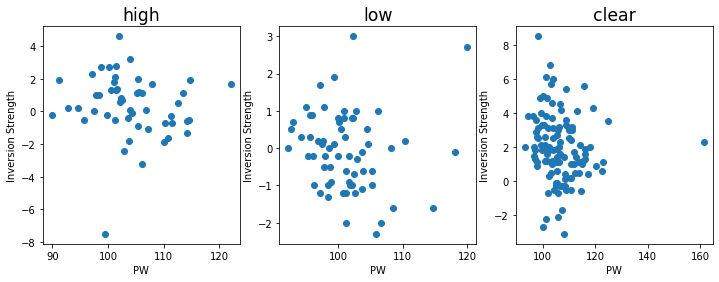

rhi_high
LinregressResult(slope=-0.00014425206758704646, intercept=0.38197631826712664, rvalue=-0.0013227563574382626, pvalue=0.992649847121503, stderr=0.015579150372307664, intercept_stderr=1.6749495328678892)
LinregressResult(slope=0.004030407560164016, intercept=-0.42726584790687766, rvalue=0.07872686624933047, pvalue=0.5330417868012782, stderr=0.006429921581146247, intercept_stderr=0.5955295316854581)
LinregressResult(slope=-4.848615418680954e-05, intercept=1.9634382832732016, rvalue=-0.0004489838869479208, pvalue=0.9962172396455062, stderr=0.010204175695978498, intercept_stderr=0.9995996281465758)


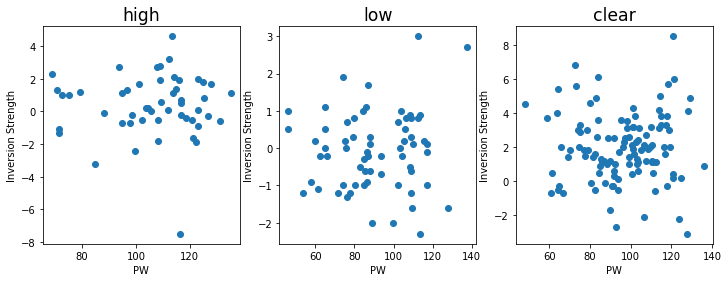

rhi_tot
LinregressResult(slope=0.00164403107962133, intercept=0.1953599427044351, rvalue=0.01266556998877384, pvalue=0.9297086764448268, stderr=0.018541821994585077, intercept_stderr=1.950484233427412)
LinregressResult(slope=0.0037166290594474244, intercept=-0.4020682489186491, rvalue=0.06081927203516707, pvalue=0.6303229211621333, stderr=0.007684807842318799, intercept_stderr=0.7130383872587399)
LinregressResult(slope=-0.00031365236227863763, intercept=1.988851748968168, rvalue=-0.0024779610820225783, pvalue=0.97912505824939, stderr=0.011960345817392297, intercept_stderr=1.1620712258963217)


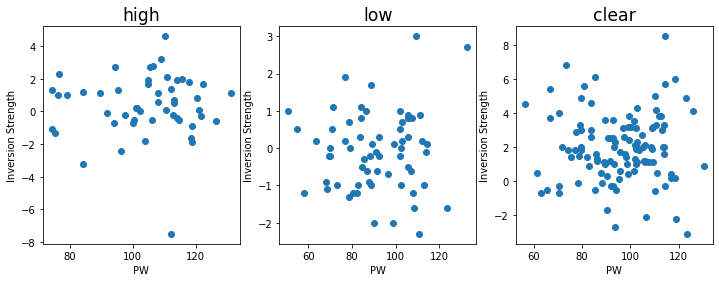

In [15]:
for var in ['pw_tot','pw_low','pw_high','rhi_low','rhi_high','rhi_tot']:
    print(var)

    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

    big_ones = []

    for name,ax in zip(['high','low','clear'],[ax1,ax2,ax3]):

        code, pw = x['code'][name],x[var][name]

        valid = df.loc[code].copy()

        valid['code'] = code
        valid['pw_clean'] = pw
        valid = valid[valid['min_altitude']<100]
        valid = valid[valid['max_altitude']>10_000]
        valid = valid[valid['Wind speed']<2.5]
    #     valid = valid[valid['pw_clean']<20]
#         print(valid.shape)

        if name == 'cloudy':
            big_ones+=list(valid[valid['pw_clean']>7].index)

        valid = valid.dropna()

        ax.set_title(name,fontsize='xx-large')
        ax.scatter(valid['pw_clean'],valid['diff'])

        print(linregress(valid['pw_clean'],valid['diff']))

        ax.set_xlabel('PW')
        ax.set_ylabel('Inversion Strength')
    plt.show()

high
3.6639208777463015
low
5.244542817337182


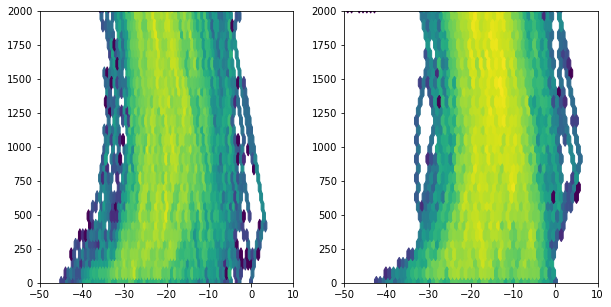

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

for name,ax in zip(['high','low'],[ax1,ax2]):

    temps, alts = x['temperature'][name],x['altitude'][name]
    
    print(name)
    print(np.nanmean(x['pw_tot'][name]))
    
#     df = pd.DataFrame({'t':temps,'a':alts})
    
#     df = df.dropna()
    
    ax.set_ylim(0,2000)
    ax.set_xlim(-50,10)
    
#     ax.hexbin(df['t'],df['a'],bins='log',mincnt=1,yscale='log')
    ax.hexbin(temps,alts,bins='log',mincnt=1)
    
plt.show()

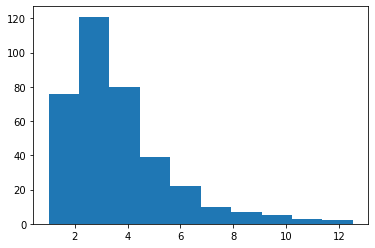

high
Total column precipitable water: 3.1426949717286687
Higher column precipitable water: 1.4871372987719251
Lower column precipitable water: 1.6228760973617415
Low level RH_i: 103.63865709094888
High level RH_i: 103.60509652687375
Inversion Strength: 0.26217616580310876



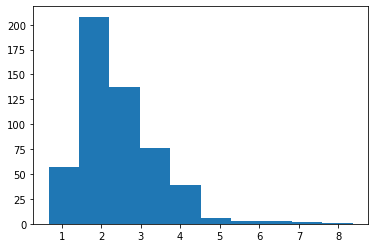

clear
Total column precipitable water: 2.2193974706485133
Higher column precipitable water: 1.0416277524878255
Lower column precipitable water: 1.2064237596592693
Low level RH_i: 105.46093410032844
High level RH_i: 91.90090760075124
Inversion Strength: 1.53265306122449



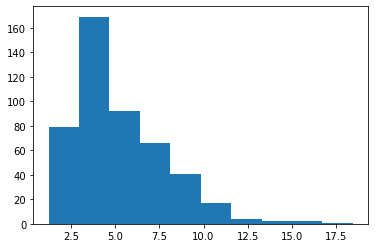

low
Total column precipitable water: 4.538198464767482
Higher column precipitable water: 1.974828104939079
Lower column precipitable water: 2.5128156921116482
Low level RH_i: 101.19308611660458
High level RH_i: 93.26074704489884
Inversion Strength: 0.0866666666666666



In [21]:
for name,ax in zip(['high','clear','low'],[ax1,ax2,ax3]):

    temps, alts = np.array(x['rh_i'][name]),np.array(x['altitude'][name])
    
    diffs = np.array(x['diff'][name])
    
    plt.hist(x['pw_tot'][name])
    plt.show()
    
    print(name)
    print(f"Total column precipitable water: {np.nanmedian(x['pw_tot'][name])}")
    print(f"Higher column precipitable water: {np.nanmedian(x['pw_high'][name])}")
    print(f"Lower column precipitable water: {np.nanmedian(x['pw_low'][name])}")


    print(f"Low level RH_i: {np.nanmean(np.nanmean(x['rhi_low'][name]))}")
    print(f"High level RH_i: {np.nanmean(np.nanmean(x['rhi_high'][name]))}")
    print(f'Inversion Strength: {np.nanmean(diffs)}')
    print()

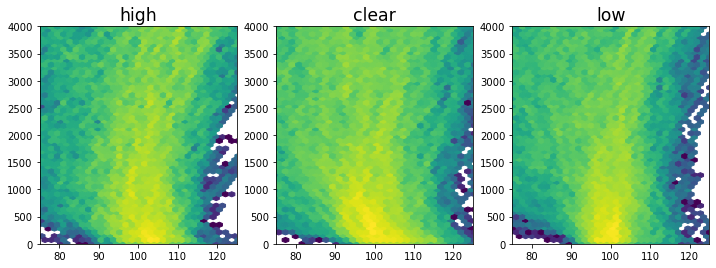

In [23]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

for name,ax in zip(['high','clear','low'],[ax1,ax2,ax3]):

    temps, alts = np.array(x['rh_i'][name]),np.array(x['altitude'][name])
    
    diffs = np.array(x['diff'][name])

    ax.set_ylim(0,4_000)
    ax.set_xlim(75,125)
    
    ax.axvline(0,color='k')
    
    ax.set_title(name,fontsize='xx-large')
    ax.hexbin(temps,alts,bins='log',mincnt=1)

#     ax.scatter(temps,alts,alpha=0.1)
plt.show()

In [605]:
for code in set(big_ones):
    
    print(df.loc[code]['Air temperature'])
    print(df.loc[code]['Surface temperature'])
    print()
    
    date = df.loc[code]['date']
    NP = df.loc[code]['NP']
    
    data = rawinsondes[NP][date]['data']
    
    plt.plot(data['temperature'],data['dewpoint'],marker='o')
    
    plt.ylim(0,20_000)
    
    plt.yscale('log')

# Cloud types

In [607]:
c6 = c[c['LOWER_CLOUD']==6]
c5 = c[c['LOWER_CLOUD']==5]

np.nanmean(c6['precipitable_water']),np.nanmean(c5['precipitable_water'])

(12.442561071710951, 3.529088264982176)

In [428]:
np.nanmean(c6['diff']),np.nanmean(c5['diff'])

(0.6147058823529411, 0.36363636363636365)

(array([3., 5., 7., 7., 7., 1., 1., 1., 0., 2.]),
 array([-1.1 , -0.61, -0.12,  0.37,  0.86,  1.35,  1.84,  2.33,  2.82,
         3.31,  3.8 ]),
 <BarContainer object of 10 artists>)

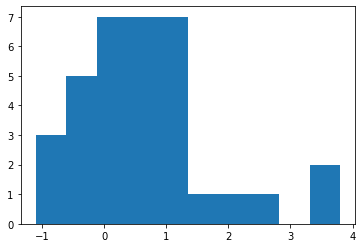

In [608]:
plt.hist(c6['diff'])

(array([ 2.,  6., 29., 31., 11.,  6.,  1.,  0.,  1.,  1.]),
 array([-1.7 , -1.08, -0.46,  0.16,  0.78,  1.4 ,  2.02,  2.64,  3.26,
         3.88,  4.5 ]),
 <BarContainer object of 10 artists>)

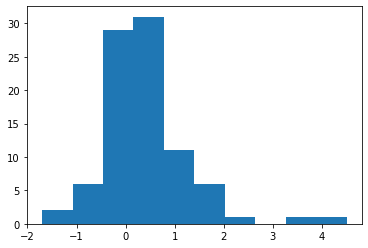

In [609]:
plt.hist(c5['diff'])

In [50]:
df_inv = df[df['inversion_depth']<5000]

df_inv = df_inv[~np.isnan(df_inv['inversion_depth'])]

df_inv['it_diff'] = df_inv['inversion_temperature']-df_inv['Surface temperature']

df_cloudy_low = df_inv[df_inv['Low cloudiness']>9]
df_clear_total = df_inv[df_inv['Total cloudiness']<1]
df_clear_low = df_inv[df_inv['Low cloudiness']<1]
df_cloudy_high = df_clear_low[df_clear_low['Total cloudiness']>8]

(array([  38.,  488., 1896., 1949.,  849.,  218.,   18.,    9.,    0.,
           3.]),
 array([-40.1 , -33.11, -26.12, -19.13, -12.14,  -5.15,   1.84,   8.83,
         15.82,  22.81,  29.8 ]),
 <BarContainer object of 10 artists>)

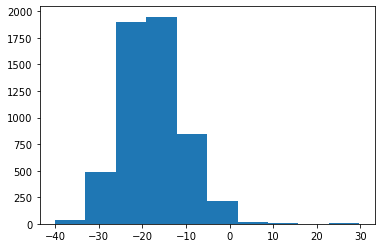

In [51]:
plt.hist(df_inv['inversion_temperature'])

(array([3.000e+00, 1.910e+02, 1.500e+03, 2.392e+03, 1.293e+03, 8.200e+01,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([-14.1 ,  -6.81,   0.48,   7.77,  15.06,  22.35,  29.64,  36.93,
         44.22,  51.51,  58.8 ]),
 <BarContainer object of 10 artists>)

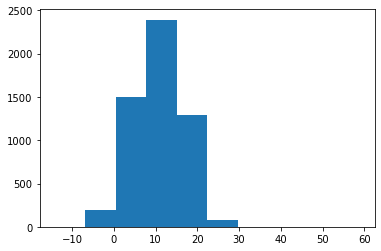

In [52]:
plt.hist(df_inv['it_diff'])

All Sky
5468
temp
LinregressResult(slope=1.8913224308105332, intercept=9.303183619249786, rvalue=0.46355051325929403, pvalue=1.6915739975091567e-289, stderr=0.04889922415001743, intercept_stderr=0.08207008346680045)
depth
no corr

Low Cloud
1031
temp
LinregressResult(slope=0.9482890656008838, intercept=5.799563110262672, rvalue=0.23715994651932493, pvalue=1.1992608529356307e-14, stderr=0.1210936531823319, intercept_stderr=0.16242478451123546)
depth
no corr

High Cloud
821
temp
LinregressResult(slope=1.2343796093528439, intercept=8.550275983813082, rvalue=0.29672775776374993, pvalue=3.768262479737733e-18, stderr=0.13881447510441763, intercept_stderr=0.18495812654440985)
depth
no corr

Clear Sky
1420
temp
LinregressResult(slope=1.2460191217652754, intercept=13.154121494497831, rvalue=0.43453220563137646, pvalue=1.7843801641419217e-66, stderr=0.06858414212793387, intercept_stderr=0.13985041084445807)
depth
no corr



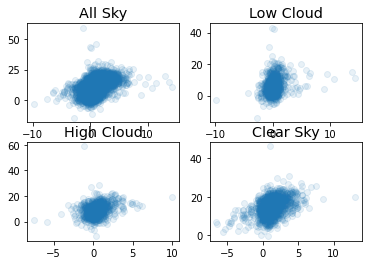

In [53]:
fig,axs=plt.subplots(2,2)

for dfc_,name,ax,color in zip([df_inv,df_cloudy_low,df_cloudy_high,df_clear_total],
                        ['All Sky','Low Cloud','High Cloud','Clear Sky'],
                        axs.reshape(-1),
                             ['r',c3,c1,c2]):
    
    print(name)
    print(dfc_.shape[0])
    print('temp')
    lrt=linregress(dfc_['diff'],dfc_['it_diff'])
    if lrt[3]<0.05:
        print(lrt)
    else:
        print('no corr')
        
    ax.scatter(dfc_['diff'],dfc_['it_diff'],alpha=0.1)
    ax.set_title(name,fontsize='x-large')
        
    
    print('depth')
    lrt=linregress(dfc_['diff'],dfc_['inversion_depth'])
    if lrt[3]<0.05:
        print(lrt)
    else:
        print('no corr')
        
    print()

(1396, 53)


LinregressResult(slope=-0.6039678143313837, intercept=-13.528263929298241, rvalue=-0.11373443498511537, pvalue=2.0489348776890378e-05, stderr=0.1413068436610539, intercept_stderr=0.1927654488974023)

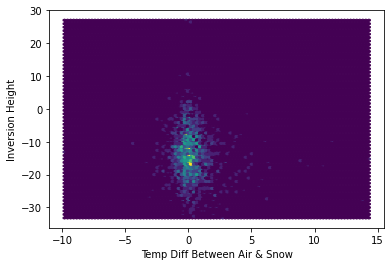

In [38]:
# df_clear_inv = df_inv[df_inv['Total cloudiness']<1]

plt.hexbin(df_clear_inv['diff'],df_clear_inv['inversion_temperature'])
# plt.xlim(-5,5)
# plt.ylim(0,2000)
plt.xlabel('Temp Diff Between Air & Snow')
plt.ylabel('Inversion Height')
# plt.ylim(-0.05,0.05)
print(df_clear_inv.shape)


# Plot relationship between the steepness of the inversion aloft and the surface inversion

In [ ]:
clean_grads = df_clear_inv[np.isfinite(df_clear_inv['inv_gradient'])]

clean_grads = clean_grads[clean_grads['inv_gradient']>0]

plt.scatter(clean_grads['inv_gradient'],clean_grads['diff'])

plt.xlabel('Temp Diff')

plt.ylabel('Inversion Gradient\n(degrees C per metre)')

plt.xlim(0,0.1)

linregress(clean_grads['inv_gradient'],clean_grads['diff'])

# Plot the relationship between the clear-sky inversions height and the surface temperature difference

In [ ]:
df_inv = df[df['inv_h']<5000]
df_inv = df_inv[~np.isnan(df_inv['inv_h'])]
df_clear_inv = df_inv[df_inv['Low cloudiness']<1]

plt.hexbin(df_clear_inv['diff'],df_clear_inv['inv_h'])
plt.xlim(-5,5)
plt.ylim(0,2000)
plt.xlabel('Temp Diff Between Air & Snow')
plt.ylabel('Inversion Height')

print(df_clear_inv.shape)

linregress(df_clear_inv['diff'],df_clear_inv['inv_h'])

# Same plot as above but for all sky conditions

In [ ]:
df_inv = df[df['inv_h']<5000]
df_inv = df_inv[~np.isnan(df_inv['inv_h'])]
df_clear_inv = df_inv[df_inv['Low cloudiness']>9]

plt.hexbin(df_clear_inv['diff'],df_clear_inv['inv_h'])
plt.xlim(-5,5)
plt.ylim(0,2000)
plt.xlabel('Temp Diff Between Air & Snow')
plt.ylabel('Inversion Height')

print(df_clear_inv.shape)

In [ ]:
plt.hexbin(df['doy'],df['diff'])
plt.ylabel('AT-SST (deg C)')
plt.xlabel('Days after Jan 1st')
plt.axhline(0,color='r')
plt.ylim(-5,5)
plt.show()